# [GD12]-(연습) 직접 만들어보는 OCR

## 데이터 다운로드

앞으로 만들어볼 Recognition model을 학습하기 위해 MJ Synth를 사용해보도록 하겠습니다. 아래의 링크는 Naver Clova의 논문 저자들이 Dropbox를 통해 제공하는 데이터셋입니다.  
path 설정 후 아래 링크의 training 폴더에서 data_lmdb_release.zip 파일을 다운로드 받아주세요! 오늘 우리는 이 20GB가 넘는 압축파일에 포함된 데이터 중에서 MJ 데이터만 활용할 예정입니다.  
```
$ mkdir -p ~/aiffel/ocr
$ cd ~/aiffel/ocr
$ wget https://www.dropbox.com/sh/i39abvnefllx2si/AABX4yjNn2iLeKZh1OAwJUffa/data_lmdb_release.zip
$ unzip data_lmdb_release.zip
$ mv data_lmdb_release/training/MJ .  # data_lmdb_release/training/MJ 아래의 데이터만 ~/aiffel/ocr 아래로 가져옵니다.
# 이후 불필요한 data_lmdb_release.zip 및 data_lmdb_release 하위의 남은 데이터는 삭제하셔도 무방합니다.
```

In [1]:
path = 'D:/geom/Aiffel/GD_12_endtoend_OCR/data_lmdb_release/training/MJ'
print(path)

D:/geom/Aiffel/GD_12_endtoend_OCR/data_lmdb_release/training/MJ


## End-to-end learning  
- “끝에서 끝을 잇는”
- 입력에서 출력까지 파이프라인 네트워크 없이 신경망으로 한번에 처리한다는 의미
- 파이프라인 네트워크란 전체 네트워크를 이루는 부분적인 네트워크
- 예를 들어, 기존의 speech recognition system은 “MFCC로 음성 파일의 특징 추출 → ML 알고리즘으로 음소를 알아냄 → 음소들로 단어를 만듦 → words 출력”같은 복잡한 과정을 거치지만 end-to-end learning은 음성 파일에서 바로 출력
    
    <img src = "https://user-images.githubusercontent.com/76797423/211483943-e6e1f323-53ae-4b0d-8e5a-73fe7a52bba9.png"> 
  
- ML/DL 논문에서 end-to-end trainable network란 모델의 모든 매개변수가 하나의 손실함수에 대해 동시에 훈련되는 경로가 가능한 네트워크를 의미
- 즉, 신경망의 입력 및 출력을 직접 고려하여 네트워크 가중치를 최적화 할 수 있음
- 장점
    - 충분한 라벨링 데이터가 있으면 신경망 모델로 해결 가능
    - 직접 파이프라인을 설계할 필요가 줄어듦 (예: 사람이 feature 추출할 필요 없음)
- 단점
    - 신경망에 너무 많은 계층의 노드가 있거나 메모리가 부족할 경우 end-to-end learning으로 학습 불가
    - 문제가 복잡할수록 전체를 파이프라인 네트워크로 나눠서 해결하는 것이 더 효율적일 수 있음

## 12-4. Recognition model (1)

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


먼저 lmdb를 설치합니다. LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자입니다. 오늘 우리가 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있습니다.  
```
$ pip install lmdb
```

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from keras import layers, Model
# from keras.models import Model
from keras.utils import Sequence
from keras import backend as K
from keras.models import load_model

BATCH_SIZE = 128

# 로컬 사용자
TRAIN_DATA_PATH = os.path.join(path + '/MJ_train')
VALID_DATA_PATH = os.path.join(path + '/MJ_valid')
TEST_DATA_PATH = os.path.join(path + '/MJ_test')

# 클라우드 사용자는 아래 주석을 사용해 주세요.
# TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
# VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
# TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
print(TRAIN_DATA_PATH)

D:/geom/Aiffel/GD_12_endtoend_OCR/data_lmdb_release/training/MJ/MJ_train


## 12-5. Recognition model (2) Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


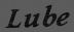

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


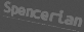

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


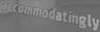

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


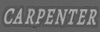

In [4]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

## 12-6. Recognition model (3) Encode

In [6]:
class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## 12-7. Recognition model (4) Build CRNN model

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

## 12-8. Recognition model (5) Train & Inference

In [10]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

ckpt_dir = 'D:/geom/Aiffel/GD_12_endtoend_OCR/ckpt'
checkpoint_path = ckpt_dir + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
history = model.fit(train_set, 
                    steps_per_epoch=len(val_set), 
                    epochs=500, 
                    validation_data=val_set, 
                    validation_steps=len(val_set), 
                    callbacks=[ckp])

Epoch 1/500
63/63 [==============================] - ETA: 0s - loss: 29.1407
Epoch 1: val_loss improved from inf to 27.07867, saving model to D:/geom/Aiffel/GD_12_endtoend_OCR/ckpt\model_checkpoint.hdf5
63/63 [==============================] - 22s 198ms/step - loss: 29.1407 - val_loss: 27.0787
Epoch 2/500
63/63 [==============================] - ETA: 0s - loss: 26.6166
Epoch 2: val_loss improved from 27.07867 to 26.26466, saving model to D:/geom/Aiffel/GD_12_endtoend_OCR/ckpt\model_checkpoint.hdf5
63/63 [==============================] - 12s 187ms/step - loss: 26.6166 - val_loss: 26.2647
Epoch 3/500
63/63 [==============================] - ETA: 0s - loss: 26.0406
Epoch 3: val_loss did not improve from 26.26466
63/63 [==============================] - 12s 185ms/step - loss: 26.0406 - val_loss: 27.4477
Epoch 4/500
63/63 [==============================] - ETA: 0s - loss: 25.5773
Epoch 4: val_loss improved from 26.26466 to 25.96317, saving model to D:/geom/Aiffel/GD_12_endtoend_OCR/ckpt\mo

In [11]:
hist = history.history

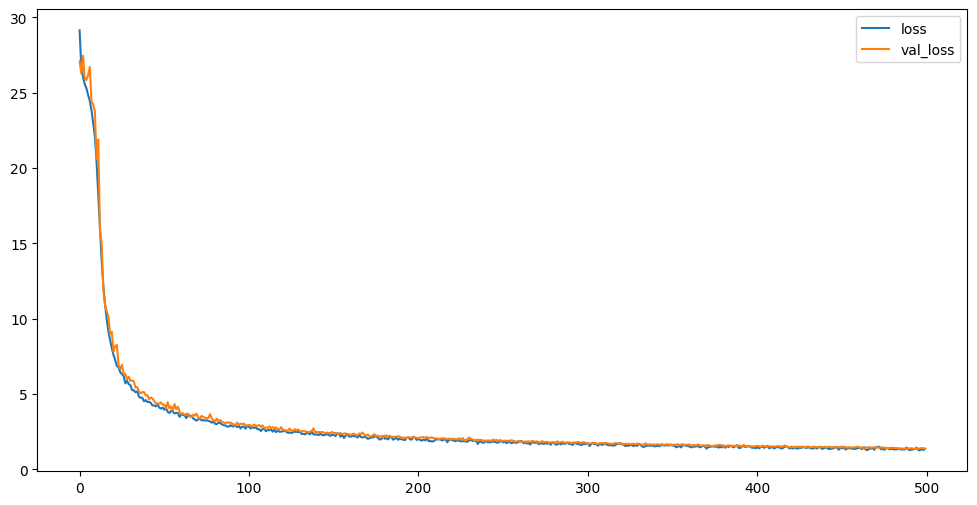

In [18]:
import matplotlib.pyplot as plt
#### 학습 결과 그래프로 표현 ###########################################################
plt.figure(figsize=(12,6))
plt.plot(hist['loss'],label='loss')
plt.plot(hist['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [19]:
# plt.plot(hist['accuracy'],label='accuracy')
# plt.plot(hist['val_accuracy'],label='val_accuracy')
# plt.legend()
# plt.show()

1/1 [==============================] - 1s 978ms/step
Result: 	 SLINKING9999999999999999


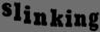

1/1 [==============================] - 0s 19ms/step
Result: 	 ALEPPO99999999999999999


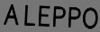

1/1 [==============================] - 0s 20ms/step
Result: 	 RWANDA999999999999999999


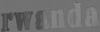

1/1 [==============================] - 0s 18ms/step
Result: 	 NATHANS99999999999999999


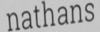

1/1 [==============================] - 0s 22ms/step
Result: 	 HALLO999999999999999999


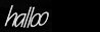

1/1 [==============================] - 0s 20ms/step
Result: 	 HURLS9999999999999999999


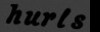

1/1 [==============================] - 0s 23ms/step
Result: 	 DOWNSIZE9999999999999999


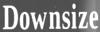

1/1 [==============================] - 0s 19ms/step
Result: 	 ROBOTIC99999999999999999


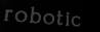

1/1 [==============================] - 0s 21ms/step
Result: 	 SLOPPY99999999999999999


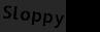

1/1 [==============================] - 0s 21ms/step
Result: 	 HERMITE99999999999999999


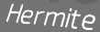

In [20]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)